In [1]:
!pip install libsvm
!pip install svm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.7.9/install/bin/python3.7 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.7.9/install/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Adapted from https://learnopencv.com/image-quality-assessment-brisque/
import cv2
import numpy as np
import math as m
import sys
# for gamma function, called 
from scipy.special import gamma as tgamma
import os
from libsvm.svmutil import * 



im = cv2.imread("frames/frame1.jpg", 0) # read as gray scale
blurred = cv2.GaussianBlur(im, (7, 7), 1.166) # apply gaussian blur to the image
blurred_sq = blurred * blurred
sigma = cv2.GaussianBlur(im * im, (7, 7), 1.166)
sigma = (sigma - blurred_sq) ** 0.5
sigma = sigma + 1.0/255 # to make sure the denominator doesn't give DivideByZero Exception
structdis = (im - blurred)/sigma # final MSCN(i, j) image

In [3]:
# AGGD fit model, takes input as the MSCN Image / Pair-wise Product
def AGGDfit(structdis):
    # variables to count positive pixels / negative pixels and their squared sum
    poscount = 0
    negcount = 0
    possqsum = 0
    negsqsum = 0
    abssum   = 0

    poscount = len(structdis[structdis > 0]) # number of positive pixels
    negcount = len(structdis[structdis < 0]) # number of negative pixels
    
    # calculate squared sum of positive pixels and negative pixels
    possqsum = np.sum(np.power(structdis[structdis > 0], 2))
    negsqsum = np.sum(np.power(structdis[structdis < 0], 2))
    
    # absolute squared sum
    abssum = np.sum(structdis[structdis > 0]) + np.sum(-1 * structdis[structdis < 0])

    # calculate left sigma variance and right sigma variance
    lsigma_best = np.sqrt((negsqsum/negcount))
    rsigma_best = np.sqrt((possqsum/poscount))

    gammahat = lsigma_best/rsigma_best
    
    # total number of pixels - totalcount
    totalcount = structdis.shape[1] * structdis.shape[0]

    rhat = m.pow(abssum/totalcount, 2)/((negsqsum + possqsum)/totalcount)
    rhatnorm = rhat * (m.pow(gammahat, 3) + 1) * (gammahat + 1)/(m.pow(m.pow(gammahat, 2) + 1, 2))
    
    prevgamma = 0
    prevdiff  = 1e10
    sampling  = 0.001
    gam = 0.2

    # vectorized function call for best fitting parameters
    vectfunc = np.vectorize(func, otypes = [np.float], cache = False)
    
    # calculate best fit params
    gamma_best = vectfunc(gam, prevgamma, prevdiff, sampling, rhatnorm)

    return [lsigma_best, rsigma_best, gamma_best] 

In [4]:
def func(gam, prevgamma, prevdiff, sampling, rhatnorm):
    while(gam < 10):
        r_gam = tgamma(2/gam) * tgamma(2/gam) / (tgamma(1/gam) * tgamma(3/gam))
        diff = abs(r_gam - rhatnorm)
        if(diff > prevdiff): break
        prevdiff = diff
        prevgamma = gam
        gam += sampling
    gamma_best = prevgamma
    return gamma_best

In [5]:
def compute_features(img):
    scalenum = 2
    feat = []
    # make a copy of the image 
    im_original = img.copy()

    # scale the images twice 
    for itr_scale in range(scalenum):
        im = im_original.copy()
        # normalize the image
        im = im / 255.0

        # calculating MSCN coefficients
        mu = cv2.GaussianBlur(im, (7, 7), 1.166)
        mu_sq = mu * mu
        sigma = cv2.GaussianBlur(im*im, (7, 7), 1.166)
        sigma = (sigma - mu_sq)**0.5
        
        # structdis is the MSCN image
        structdis = im - mu
        structdis /= (sigma + 1.0/255)
        
        # calculate best fitted parameters from MSCN image
        best_fit_params = AGGDfit(structdis)
        # unwrap the best fit parameters 
        lsigma_best = best_fit_params[0]
        rsigma_best = best_fit_params[1]
        gamma_best  = best_fit_params[2]
        
        # append the best fit parameters for MSCN image
        feat.append(gamma_best)
        feat.append((lsigma_best*lsigma_best + rsigma_best*rsigma_best)/2)

        # shifting indices for creating pair-wise products
        shifts = [[0,1], [1,0], [1,1], [-1,1]] # H V D1 D2

        for itr_shift in range(1, len(shifts) + 1):
            OrigArr = structdis
            reqshift = shifts[itr_shift-1] # shifting index

            # create transformation matrix for warpAffine function
            M = np.float32([[1, 0, reqshift[1]], [0, 1, reqshift[0]]])
            ShiftArr = cv2.warpAffine(OrigArr, M, (structdis.shape[1], structdis.shape[0]))
            
            Shifted_new_structdis = ShiftArr
            Shifted_new_structdis = Shifted_new_structdis * structdis
            # shifted_new_structdis is the pairwise product 
            # best fit the pairwise product 
            best_fit_params = AGGDfit(Shifted_new_structdis)
            lsigma_best = best_fit_params[0]
            rsigma_best = best_fit_params[1]
            gamma_best  = best_fit_params[2]

            constant = m.pow(tgamma(1/gamma_best), 0.5)/m.pow(tgamma(3/gamma_best), 0.5)
            meanparam = (rsigma_best - lsigma_best) * (tgamma(2/gamma_best)/tgamma(1/gamma_best)) * constant

            # append the best fit calculated parameters            
            feat.append(gamma_best) # gamma best
            feat.append(meanparam) # mean shape
            feat.append(m.pow(lsigma_best, 2)) # left variance square
            feat.append(m.pow(rsigma_best, 2)) # right variance square
        
        # resize the image on next iteration
        im_original = cv2.resize(im_original, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
    return feat

In [6]:

def test_measure_BRISQUE(img):
    # read image from given path
    dis = img
    if(dis is None):
        print("Wrong image path given")
        print("Exiting...")
        sys.exit(0)
    # convert to gray scale
    dis = cv2.cvtColor(dis, cv2.COLOR_BGR2GRAY)

    # compute feature vectors of the image
    features = compute_features(dis)

    # rescale the brisqueFeatures vector from -1 to 1
    x = [0]
    
    # pre loaded lists from C++ Module to rescale brisquefeatures vector to [-1, 1]
    min_= [0.336999 ,0.019667 ,0.230000 ,-0.125959 ,0.000167 ,0.000616 ,0.231000 ,-0.125873 ,0.000165 ,0.000600 ,0.241000 ,-0.128814 ,0.000179 ,0.000386 ,0.243000 ,-0.133080 ,0.000182 ,0.000421 ,0.436998 ,0.016929 ,0.247000 ,-0.200231 ,0.000104 ,0.000834 ,0.257000 ,-0.200017 ,0.000112 ,0.000876 ,0.257000 ,-0.155072 ,0.000112 ,0.000356 ,0.258000 ,-0.154374 ,0.000117 ,0.000351]
    
    max_= [9.999411, 0.807472, 1.644021, 0.202917, 0.712384, 0.468672, 1.644021, 0.169548, 0.713132, 0.467896, 1.553016, 0.101368, 0.687324, 0.533087, 1.554016, 0.101000, 0.689177, 0.533133, 3.639918, 0.800955, 1.096995, 0.175286, 0.755547, 0.399270, 1.095995, 0.155928, 0.751488, 0.402398, 1.041992, 0.093209, 0.623516, 0.532925, 1.042992, 0.093714, 0.621958, 0.534484]

    # append the rescaled vector to x 
    for i in range(0, 36):
        min = min_[i]
        max = max_[i] 
        x.append(-1 + (2.0/(max - min) * (features[i] - min)))
    
    # load model 
    model = svm_load_model("allmodel")
    

    # create svm node array from python list
    x, idx = gen_svm_nodearray(x[1:], isKernel=(model.param.kernel_type == PRECOMPUTED))
    x[36].index = -1 # set last index to -1 to indicate the end.
    
    # get important parameters from model
    svm_type = model.get_svm_type()
    is_prob_model = model.is_probability_model()
    nr_class = model.get_nr_class()
    
    if svm_type in (ONE_CLASS, EPSILON_SVR, NU_SVC):
        # here svm_type is EPSILON_SVR as it's regression problem
        nr_classifier = 1
    dec_values = (c_double * nr_classifier)()
    
    # calculate the quality score of the image using the model and svm_node_array
    qualityscore = libsvm.svm_predict_probability(model, x, dec_values)

    return qualityscore

In [7]:
# print("Original: ",test_measure_BRISQUE('frames/frame1.jpg'))
# print("Gan: ",test_measure_BRISQUE('gan_frames/g_frame1.jpg'))
# print("Out of focus: ",test_measure_BRISQUE('oof_frames/oof_frame1.jpg'))
# print("Motion blur: ",test_measure_BRISQUE("/projectnb/cs585/reardonc/wiener_deconv_frames/w_frame1.jpg"))


In [26]:
orig_path = "frames"
gan_path = "gan_frames"
oof_path = "oof_frames"
gfn_path = "/projectnb/cs585/goutermoutn/imagedeblur/gfn-data/deblurred"
mot_path = "/projectnb/cs585/reardonc/wiener_deconv_frames"
# paths = [orig_path,gan_path,oof_path,mot_path ]
paths = [gfn_path]

In [27]:
from os import listdir
from os.path import isfile, join

def get_images(img_path):
    np.set_printoptions(threshold=sys.maxsize)

    files = [join(img_path,f) for f in listdir(img_path) if isfile(join(img_path,f)) and join(img_path,f).endswith('.jpg')]
    files.sort()
#     imgs = []
    score = 0
    count = 0
    best_score = 1000
    for i in range(len(files)):
        if(i % 2 == 0):
            current_score = test_measure_BRISQUE(cv2.imread(files[i],1))
            score += current_score
            if current_score < best_score:
                best_img = files[i]
            count += 1
            if count % 100 == 0:
                print("Scored "+str(count)+" images...")
    
    return score / count, best_img
# orig_imgs = get_images(orig_path)
# gan_imgs = get_images(gan_path)
# oof_imgs = get_images(oof_path)
# mot_imgs = get_images(mot_path)

In [28]:
count = 0
def get_score(img):
    score = 0
    best_score = 1000
    for image in imgs:
        current_score = test_measure_BRISQUE(img)
        if current_score < best_score:
            best_img = img
            
#         count += 1
#         if count % 5000 == 0:
#             print("Scored "+str(count)+" images...")
    return score, best_img
# print(get_ave_score(orig_imgs))

In [29]:
# print("Gan: ", get_ave_score(gan_imgs))
# print("Oof: ", get_ave_score(oof_imgs))
# print("Mot: ", get_ave_score(mot_imgs))

In [30]:
#BEST IMAGE FOR EACH IS 9965
for path in paths:
    ave,best_img = get_images(path)
    print(best_img)
    print("" + path,ave )

/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/

Scored 100 images...
Scored 200 images...
Scored 300 images...
Scored 400 images...
Scored 500 images...
/projectnb/cs585/goutermoutn/imagedeblur/gfn-data/deblurred/frame9900.jpg
/projectnb/cs585/goutermoutn/imagedeblur/gfn-data/deblurred 32.37475082509077


/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/

BRISQUE of Original Image: 56.06630284137077


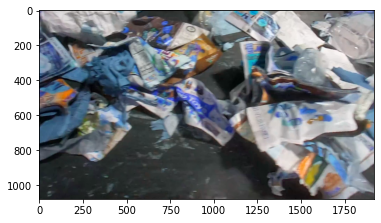

BRISQUE of OOF Deblurred Image: 33.60966670757318


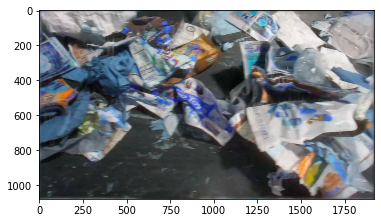

BRISQUE of Motion Deblurred Image: 40.89352941995412


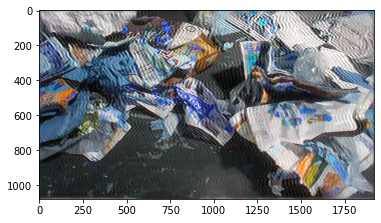

BRISQUE of GAN Deblurred Image: 56.86634511225634


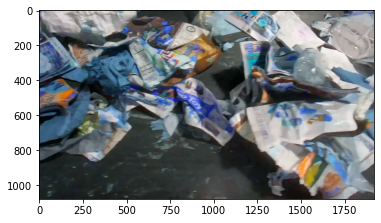

BRISQUE of GFN Deblurred Image: 34.58606668467053


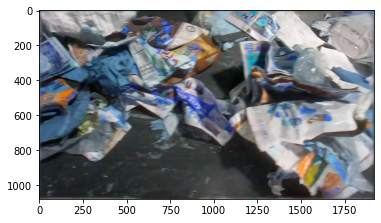

In [9]:
import matplotlib.pyplot as plt

# run niqe metrics on frame0 to test
og_path = '/projectnb/cs585/reardonc/frames/frame0.jpg'
gan_path = '/projectnb/cs585/goutermoutn/imagedeblur/gan_frames/g_frame0.jpg'
oof_path = '/projectnb/cs585/goutermoutn/imagedeblur/oof_frames/oof_frame0.jpg'
motion_path = '/projectnb/cs585/reardonc/wiener_deconv_frames/w_frame0.jpg'
gfn_path = '/projectnb/cs585/reardonc/gfn_frames/frame0.jpg'

img1 = cv2.imread(og_path, 1)
img2 = cv2.imread(oof_path, 1)
img3 = cv2.imread(motion_path, 1)
img4 = cv2.imread(gan_path, 1)
img5 = cv2.imread(gfn_path, 1)

brisque_result1 = test_measure_BRISQUE(img1)
brisque_result2 = test_measure_BRISQUE(img2)
brisque_result3 = test_measure_BRISQUE(img3)
brisque_result4 = test_measure_BRISQUE(img4)
brisque_result5 = test_measure_BRISQUE(img5)

print("BRISQUE of Original Image: "+str(brisque_result1))
plt.imshow(img1)
plt.show()
print("BRISQUE of OOF Deblurred Image: "+str(brisque_result2))
plt.imshow(img2)
plt.show()
print("BRISQUE of Motion Deblurred Image: "+str(brisque_result3))
plt.imshow(img3)
plt.show()
print("BRISQUE of GAN Deblurred Image: "+str(brisque_result4))
plt.imshow(img4)
plt.show()
print("BRISQUE of GFN Deblurred Image: "+str(brisque_result5))
plt.imshow(img5)
plt.show()


/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/

BRISQUE of Original Image: 54.756885678936214


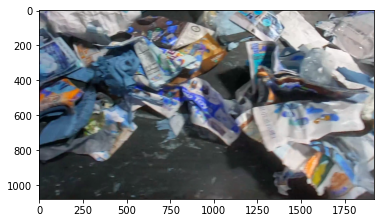

BRISQUE of OOF Deblurred Image: 35.83178613159225


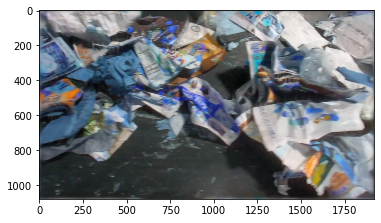

BRISQUE of Motion Deblurred Image: 40.85527858649334


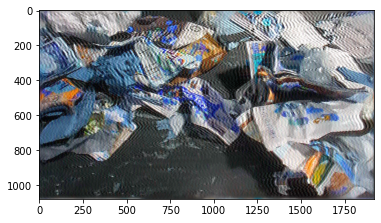

BRISQUE of GAN Deblurred Image: 43.88917981821305


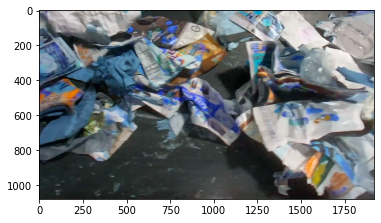

BRISQUE of GFN Deblurred Image: 33.68307739798479


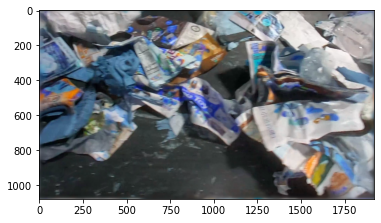

In [10]:
import matplotlib.pyplot as plt

# run niqe metrics on frame1 to test
og_path = '/projectnb/cs585/reardonc/frames/frame1.jpg'
gan_path = '/projectnb/cs585/goutermoutn/imagedeblur/gan_frames/g_frame1.jpg'
oof_path = '/projectnb/cs585/goutermoutn/imagedeblur/oof_frames/oof_frame1.jpg'
motion_path = '/projectnb/cs585/reardonc/wiener_deconv_frames/w_frame1.jpg'
gfn_path = '/projectnb/cs585/reardonc/gfn_frames/frame1.jpg'

img1 = cv2.imread(og_path)
img2 = cv2.imread(oof_path)
img3 = cv2.imread(motion_path)
img4 = cv2.imread(gan_path)
img5 = cv2.imread(gfn_path)

img1 = cv2.imread(og_path, 1)
img2 = cv2.imread(oof_path, 1)
img3 = cv2.imread(motion_path, 1)
img4 = cv2.imread(gan_path, 1)
img5 = cv2.imread(gfn_path, 1)

brisque_result1 = test_measure_BRISQUE(img1)
brisque_result2 = test_measure_BRISQUE(img2)
brisque_result3 = test_measure_BRISQUE(img3)
brisque_result4 = test_measure_BRISQUE(img4)
brisque_result5 = test_measure_BRISQUE(img5)

print("BRISQUE of Original Image: "+str(brisque_result1))
plt.imshow(img1)
plt.show()
print("BRISQUE of OOF Deblurred Image: "+str(brisque_result2))
plt.imshow(img2)
plt.show()
print("BRISQUE of Motion Deblurred Image: "+str(brisque_result3))
plt.imshow(img3)
plt.show()
print("BRISQUE of GAN Deblurred Image: "+str(brisque_result4))
plt.imshow(img4)
plt.show()
print("BRISQUE of GFN Deblurred Image: "+str(brisque_result5))
plt.imshow(img5)
plt.show()

/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/share/pkg.7/python3/3.7.9/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/

BRISQUE of Original Image: 54.03634753244853


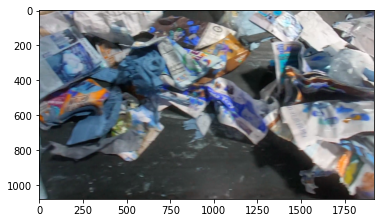

BRISQUE of OOF Deblurred Image: 38.39751445626598


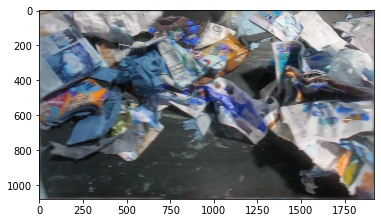

BRISQUE of Motion Deblurred Image: 41.0650267421712


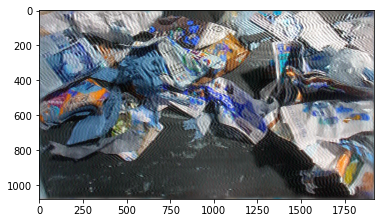

BRISQUE of GAN Deblurred Image: 50.296237285690495


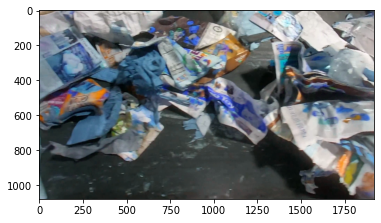

BRISQUE of GFN Deblurred Image: 33.25846362735808


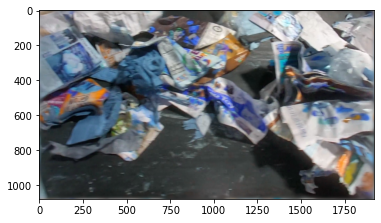

In [11]:


# compare frame 10 as well
og_path = '/projectnb/cs585/reardonc/frames/frame10.jpg'
gan_path = '/projectnb/cs585/goutermoutn/imagedeblur/gan_frames/g_frame10.jpg'
oof_path = '/projectnb/cs585/goutermoutn/imagedeblur/oof_frames/oof_frame2.jpg'
motion_path = '/projectnb/cs585/reardonc/wiener_deconv_frames/w_frame2.jpg'
gfn_path = '/projectnb/cs585/reardonc/gfn_frames/frame10.jpg'

img1 = cv2.imread(og_path, 1)
img2 = cv2.imread(oof_path, 1)
img3 = cv2.imread(motion_path, 1)
img4 = cv2.imread(gan_path, 1)
img5 = cv2.imread(gfn_path, 1)

brisque_result1 = test_measure_BRISQUE(img1)
brisque_result2 = test_measure_BRISQUE(img2)
brisque_result3 = test_measure_BRISQUE(img3)
brisque_result4 = test_measure_BRISQUE(img4)
brisque_result5 = test_measure_BRISQUE(img5)

print("BRISQUE of Original Image: "+str(brisque_result1))
plt.imshow(img1)
plt.show()
print("BRISQUE of OOF Deblurred Image: "+str(brisque_result2))
plt.imshow(img2)
plt.show()
print("BRISQUE of Motion Deblurred Image: "+str(brisque_result3))
plt.imshow(img3)
plt.show()
print("BRISQUE of GAN Deblurred Image: "+str(brisque_result4))
plt.imshow(img4)
plt.show()
print("BRISQUE of GFN Deblurred Image: "+str(brisque_result5))
plt.imshow(img5)
plt.show()